In [ ]:
!pip install -q kaggle

In [ ]:
!rm -rf /content/data/final_dataset

In [ ]:
!mkdir ~/.kaggle

In [125]:
!cp kaggle.json ~/.kaggle

In [126]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! kaggle datasets download -d riyaelizashaju/isic-skin-disease-image-dataset-labelled

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
import zipfile
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# extracting data from zip
local_zip = 'isic-skin-disease-image-dataset-labelled.zip'
target_extraction = './data/data_2'
file_check = "ISIC_Labelled"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)
        zip_ref.close()
#if data is already extracted it will instead print file already extracted
except FileNotFoundError:
    print('Zip File Not Found!')

In [ ]:
path = './data/data_2/ISIC_Labelled'

dir_new = ['melanoma', 'melanocytic_nevi', 'basal_cell_carcinoma', 'bowen_disease', 'benign_keratosis', 'dermatofibroma', 'vascular_lesions', 'squamous_cell_carcinoma']
dir_old = ['Melanoma', 'Melanocytic nevus', 'Basal cell carcinoma', 'Actinic keratosis', 'Benign keratosis', 'Dermatofibroma', 'Vascular lesion', 'Squamous cell carcinoma']

counter = 0

for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    name = os.path.splitext(filename)
    
    for i, x in enumerate(dir_old):
        if x in name:
            postfix = dir_new[i]
            new_name = os.path.join(path, postfix)
            os.rename(file_path, new_name)
            continue
    counter += 1

In [ ]:
import os
import random
import shutil

source_dir = './data/data_2/ISIC_Labelled'
train_dir = './data/final_dataset/training'
validation_dir = './data/final_dataset/validation'
class_names = ['melanoma', 'melanocytic_nevi', 'basal_cell_carcinoma', 'bowen_disease', 'benign_keratosis', 'dermatofibroma', 'vascular_lesions', 'squamous_cell_carcinoma']

train_ratio = 0.8  # Ratio of images to be used for training

# Create output directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Iterate over each class
for class_name in class_names:
    class_dir = os.path.join(source_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle the images

    train_count = int(len(images) * train_ratio)
    train_images = images[:train_count]
    validation_images = images[train_count:]

    # Move training images to train_dir
    for image in train_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Create class subdirectory if it doesn't exist
        shutil.copy(src_path, dst_path)

    # Move validation images to validation_dir
    for image in validation_images:
        src_path = os.path.join(class_dir, image)
        dst_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Create class subdirectory if it doesn't exist
        shutil.copy(src_path, dst_path)

print("Data split into train and validation sets successfully.")


Data split into train and validation sets successfully.


In [ ]:
training_main = pathlib.Path('./data/final_dataset/training')
validation_main = pathlib.Path('./data/final_dataset/validation')

In [ ]:
image_count_train = len(list(training_main.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(validation_main.glob('*/*.jpg')))
print(image_count_test)

20262
5069


In [ ]:
batch_size = 32
img_height = 150
img_width = 150
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
batch_size=batch_size)

Found 20262 files belonging to 8 classes.
Using 16210 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_main,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20262 files belonging to 8 classes.
Using 4052 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_main,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5069 files belonging to 8 classes.
Using 4562 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['basal_cell_carcinoma', 'benign_keratosis', 'bowen_disease', 'dermatofibroma', 'melanocytic_nevi', 'melanoma', 'squamous_cell_carcinoma', 'vascular_lesions']


In [ ]:
plt.figure(figsize=(10, 10))
for image, label in train_dataset.take(1):
    for i in range (9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

NameError: ignored

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

total training image count = 20262 

-------------------------------------
Class name =  basal_cell_carcinoma
count      =  2658
proportion =  0.1311815220610009
-------------------------------------
Class name =  benign_keratosis
count      =  2099
proportion =  0.1035929325831606
-------------------------------------
Class name =  bowen_disease
count      =  693
proportion =  0.03420195439739414
-------------------------------------
Class name =  dermatofibroma
count      =  191
proportion =  0.009426512683841674
-------------------------------------
Class name =  melanocytic_nevi
count      =  10300
proportion =  0.5083407363537656
-------------------------------------
Class name =  melanoma
count      =  3617
proportion =  0.1785114993584049
-------------------------------------
Class name =  squamous_cell_carcinoma
count      =  502
proportion =  0.024775441713552462
-------------------------------------
Class name =  vascular_lesions
count      =  202
proportion =  0.009969400848

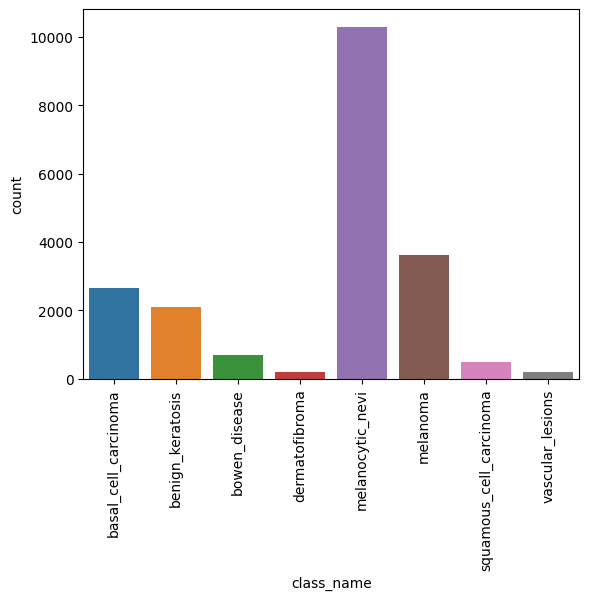

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(training_main.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(training_main.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset = "./data/final_dataset/training/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/data/augmentor_data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 2658 image(s) found.
Output directory set to /data/augmentor_data/basal_cell_carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F89043DB6A0>: 100%|██████████| 1000/1000 [02:00<00:00,  8.33 Samples/s]


Initialised with 2099 image(s) found.
Output directory set to /data/augmentor_data/benign_keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x680 at 0x7F89043DB8E0>: 100%|██████████| 1000/1000 [01:25<00:00, 11.71 Samples/s]


Initialised with 693 image(s) found.
Output directory set to /data/augmentor_data/bowen_disease/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F8907757B50>: 100%|██████████| 1000/1000 [02:02<00:00,  8.19 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /data/augmentor_data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F89041352D0>: 100%|██████████| 1000/1000 [01:25<00:00, 11.67 Samples/s]


Initialised with 10300 image(s) found.
Output directory set to /data/augmentor_data/melanocytic_nevi/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8904142E00>: 100%|██████████| 1000/1000 [01:16<00:00, 13.15 Samples/s]


Initialised with 3617 image(s) found.
Output directory set to /data/augmentor_data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F88FC297EB0>: 100%|██████████| 1000/1000 [01:38<00:00, 10.19 Samples/s]


Initialised with 502 image(s) found.
Output directory set to /data/augmentor_data/squamous_cell_carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F8993317D30>: 100%|██████████| 1000/1000 [01:38<00:00, 10.15 Samples/s]


Initialised with 202 image(s) found.
Output directory set to /data/augmentor_data/vascular_lesions/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F89043DB220>: 100%|██████████| 1000/1000 [01:15<00:00, 13.33 Samples/s]


In [ ]:
output_dir = pathlib.Path('./data/augmentor_data')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)


8000


total training image count = 8000 

-------------------------------------
Class name =  basal_cell_carcinoma
count      =  1000
-------------------------------------
Class name =  benign_keratosis
count      =  1000
-------------------------------------
Class name =  bowen_disease
count      =  1000
-------------------------------------
Class name =  dermatofibroma
count      =  1000
-------------------------------------
Class name =  melanocytic_nevi
count      =  1000
-------------------------------------
Class name =  melanoma
count      =  1000
-------------------------------------
Class name =  squamous_cell_carcinoma
count      =  1000
-------------------------------------
Class name =  vascular_lesions
count      =  1000
-------------------------------------


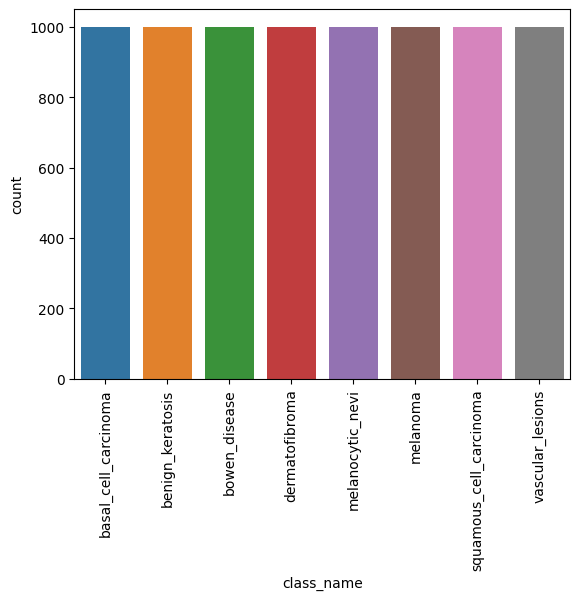

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  shuffle=True,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(150, 150),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  shuffle=True,
  seed=123,
  validation_split = 0.25,
  subset = 'validation',
  image_size=(150,150),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 2000 files for validation.


In [ ]:
print(train_ds.class_names)

['basal_cell_carcinoma', 'benign_keratosis', 'bowen_disease', 'dermatofibroma', 'melanocytic_nevi', 'melanoma', 'squamous_cell_carcinoma', 'vascular_lesions']


In [ ]:
num_classes = 8
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(100,100,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())


model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
200/200 [==============================] - 18s 88ms/step - loss: 0.0827 - accuracy: 0.9741 - val_loss: 1.6296 - val_accuracy: 0.6825
Epoch 2/25
200/200 [==============================] - 19s 94ms/step - loss: 0.0835 - accuracy: 0.9755 - val_loss: 1.6404 - val_accuracy: 0.7113
Epoch 3/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0782 - accuracy: 0.9773 - val_loss: 1.6407 - val_accuracy: 0.7013
Epoch 4/25
200/200 [==============================] - 20s 98ms/step - loss: 0.0686 - accuracy: 0.9817 - val_loss: 1.6151 - val_accuracy: 0.7075
Epoch 5/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0593 - accuracy: 0.9850 - val_loss: 1.8356 - val_accuracy: 0.6875
Epoch 6/25
200/200 [==============================] - 19s 94ms/step - loss: 0.0596 - accuracy: 0.9823 - val_loss: 1.6913 - val_accuracy: 0.7038
Epoch 7/25
200/200 [==============================] - 19s 94ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 1.7131 - val_accuracy:

In [ ]:
IMG_SIZE = (150,150)
IMG_SHAPE = IMG_SIZE + (3,)
resnet50 = tf.keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [ ]:
conv_model.trainable = False

In [ ]:
conv_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
def data_augmenter ():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        ])
    
    return data_augmentation

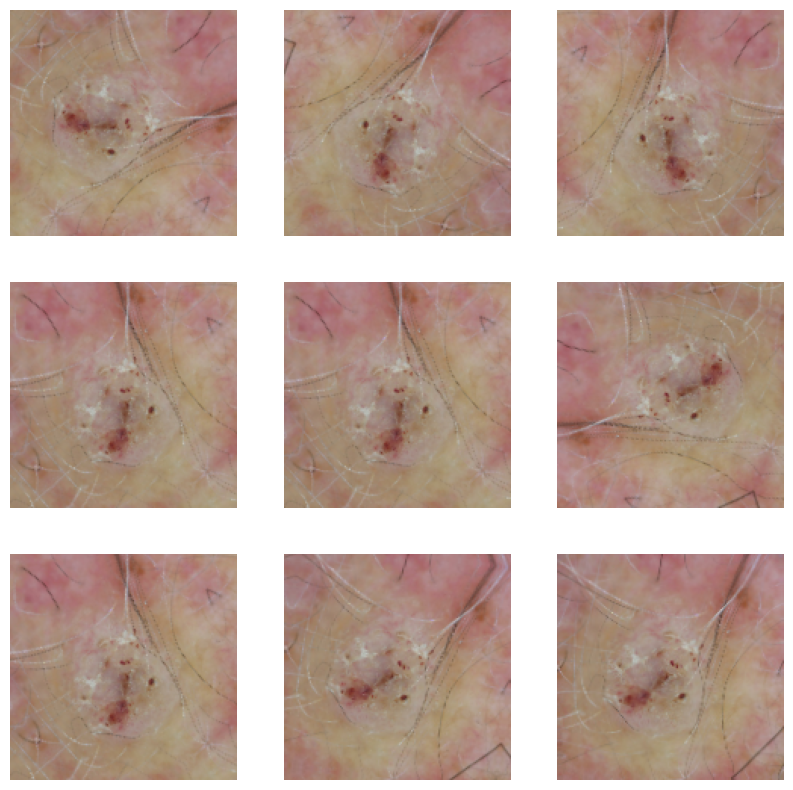

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(conv_model.output)

predictions = tf.keras.layers.Dense(8, activation='softmax')(x)
full_model = tf.keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
base_learning_rate = 0.001

full_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  metrics=['accuracy'])

In [ ]:
initial_epochs = 15
history3 =full_model.fit(train_ds, validation_data=val_ds, validation_steps=int(0.2*len(test_ds)), epochs=initial_epochs)

Epoch 1/15
200/200 [==============================] - 23s 111ms/step - loss: 0.1597 - accuracy: 0.9702 - val_loss: 0.7517 - val_accuracy: 0.8013
Epoch 2/15
200/200 [==============================] - 23s 111ms/step - loss: 0.1564 - accuracy: 0.9716 - val_loss: 0.7257 - val_accuracy: 0.8125
Epoch 3/15
200/200 [==============================] - 24s 116ms/step - loss: 0.1537 - accuracy: 0.9725 - val_loss: 0.7318 - val_accuracy: 0.8192
Epoch 4/15
200/200 [==============================] - 25s 122ms/step - loss: 0.1493 - accuracy: 0.9750 - val_loss: 0.7534 - val_accuracy: 0.8058
Epoch 5/15
200/200 [==============================] - 25s 123ms/step - loss: 0.1459 - accuracy: 0.9756 - val_loss: 0.7389 - val_accuracy: 0.8203
Epoch 6/15
200/200 [==============================] - 22s 109ms/step - loss: 0.1477 - accuracy: 0.9733 - val_loss: 0.7579 - val_accuracy: 0.7980
Epoch 7/15
200/200 [==============================] - 22s 105ms/step - loss: 0.1433 - accuracy: 0.9745 - val_loss: 0.7263 - val_ac

In [ ]:
full_model.save('./model_weights/skin_model(this_model_kinda_good).h5')

Text(0.5, 1.0, 'Training vs Validation Loss')

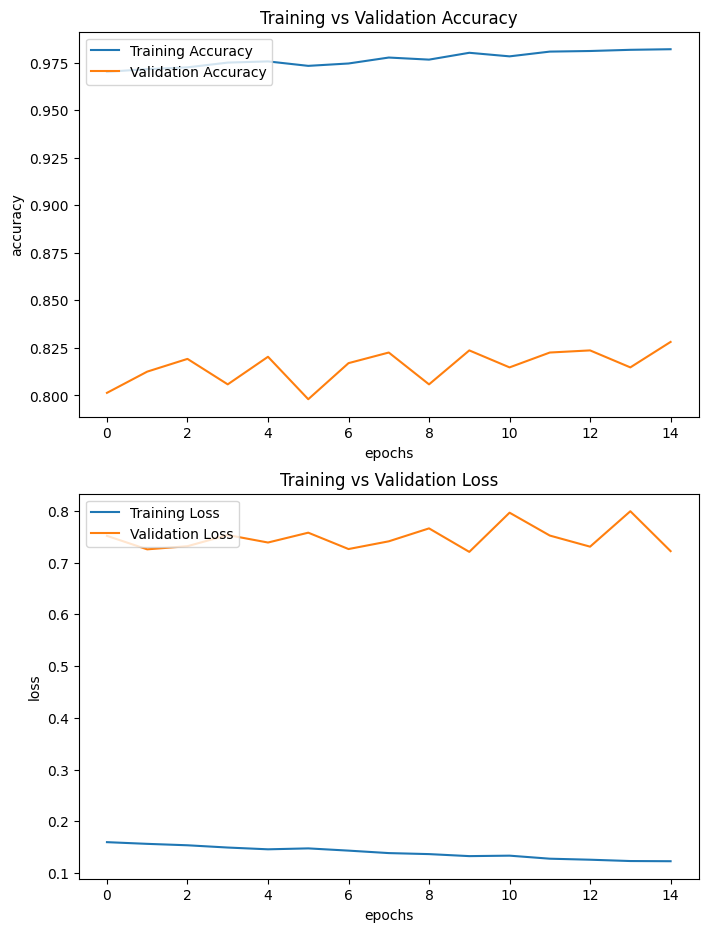

In [ ]:

acc = history3.history['accuracy']
loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 11))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Loss')